<a href="https://colab.research.google.com/github/lawrenceemenike/pytorch-deep-learning/blob/main/Replicating_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into uasable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010/11929



## 0. Get setup

Import code previously written

In [1]:
import torch
import torchvision

In [2]:
import matplotlib as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it fi it doesnt work
try:
  from torchinfo import summary
except:
  print("[INFO] couldnt find torchinfo.. installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from Github if it doesnt work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

except:
  # Get the going_modular scripts
  print("[INFO] Couldnt find going_modular or helper_functions scripts... download them from Github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] couldnt find torchinfo.. installing it.
[INFO] Couldnt find going_modular or helper_functions scripts... download them from Github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

the whole goal is to replicate the ViT transformer for our Foodvision problem

To do that, we need some data:
Namley, pizza, steak and sushi data

In [4]:
# Download pizza, steak and sushi images from Github
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test iamges
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224

# Creaet transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize([IMG_SIZE, IMG_SIZE]),
                                        transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Creae a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

Always visualize!!

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

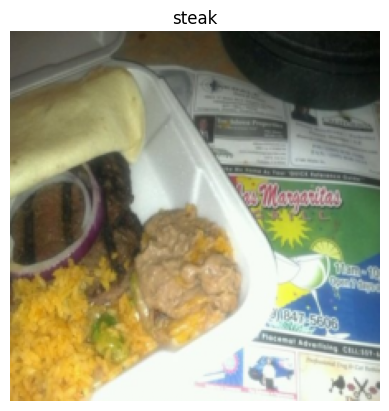

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) ->
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at  a whole machine learning research paper can be intimidating. SO in order to make it more understandable we break it down to smaller pieces:

* **inputs** - What goes into the model? (image tensors)
* **Outputs** - What comes out of the model/layer/block?
* **Layers** - Takes an inpyt, manipulates it with a function (for example could be self attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: peices of the puzzle

* Figure 1: Visual overview of the architecture
* Fiur equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training
* Text

#### Figure 1
![] (https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

#### Four equations

* **Equation 1: **
An overview of the model is depicted in Figure 1. The standard Transformer recevies as input a 1D sequnce of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image into a sequnce of flattened patches where $(H, W)$ is the resolution of the original image, $C$ is the resulting number of patches, which also serves as the effective input sequcen length for the transformer. The transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection(Eg. 1). We refere to the output of this projection as the patch embeddings.

Positional embeddings are added to the patch embeddings to retain postional information. We use standard learnable $1 \mathrom{D}$ postion embeddings, since we have not observed significant performance gains from using more advance 2D-aware position mebeddings (Appendix D.4). The resulting sequnence of embedding vectors serves as input to the encoder.

In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, .. image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos```

**Equations 2&3**: The transfomer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). layernorm (LN) is applied before every block, and resudual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_lyaer(x_input)) + x_input

# Equation 3
x_putput_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```



**Equation 4**: Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches (z = xclass), whose state at the output of the Transformer encoder serves as the iamge representation (Eq. 4). Both during pre-training and fine tuning, a classification head is attached to z. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = mutlilyaer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single layer at fine-tunining time

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1

< img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT Base, ViT-Large and Vit-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/nuerons in MLP
* Head - the number of multi-head self attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output
What's the input shape?
What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height,
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
D = constant latent vector size = embeddind dimension (see table 1)

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (singel 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (singel 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Lets visualize, visualize, visualize

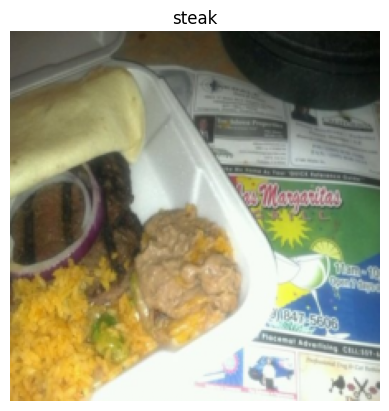

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

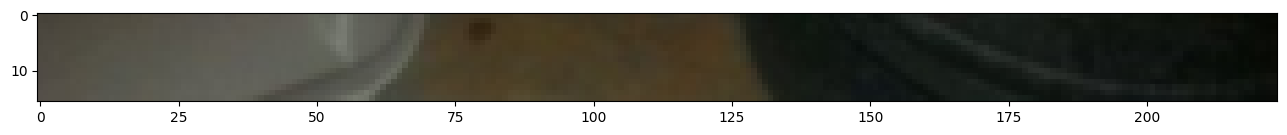

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# index to plot row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


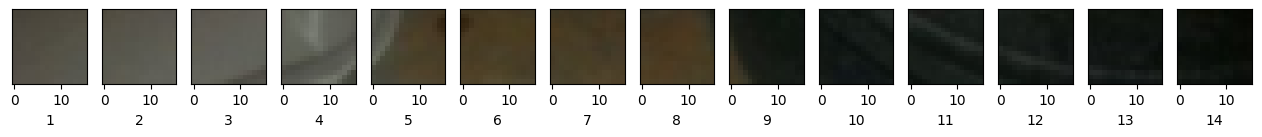

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one columns for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through m=number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of pataches per columns: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


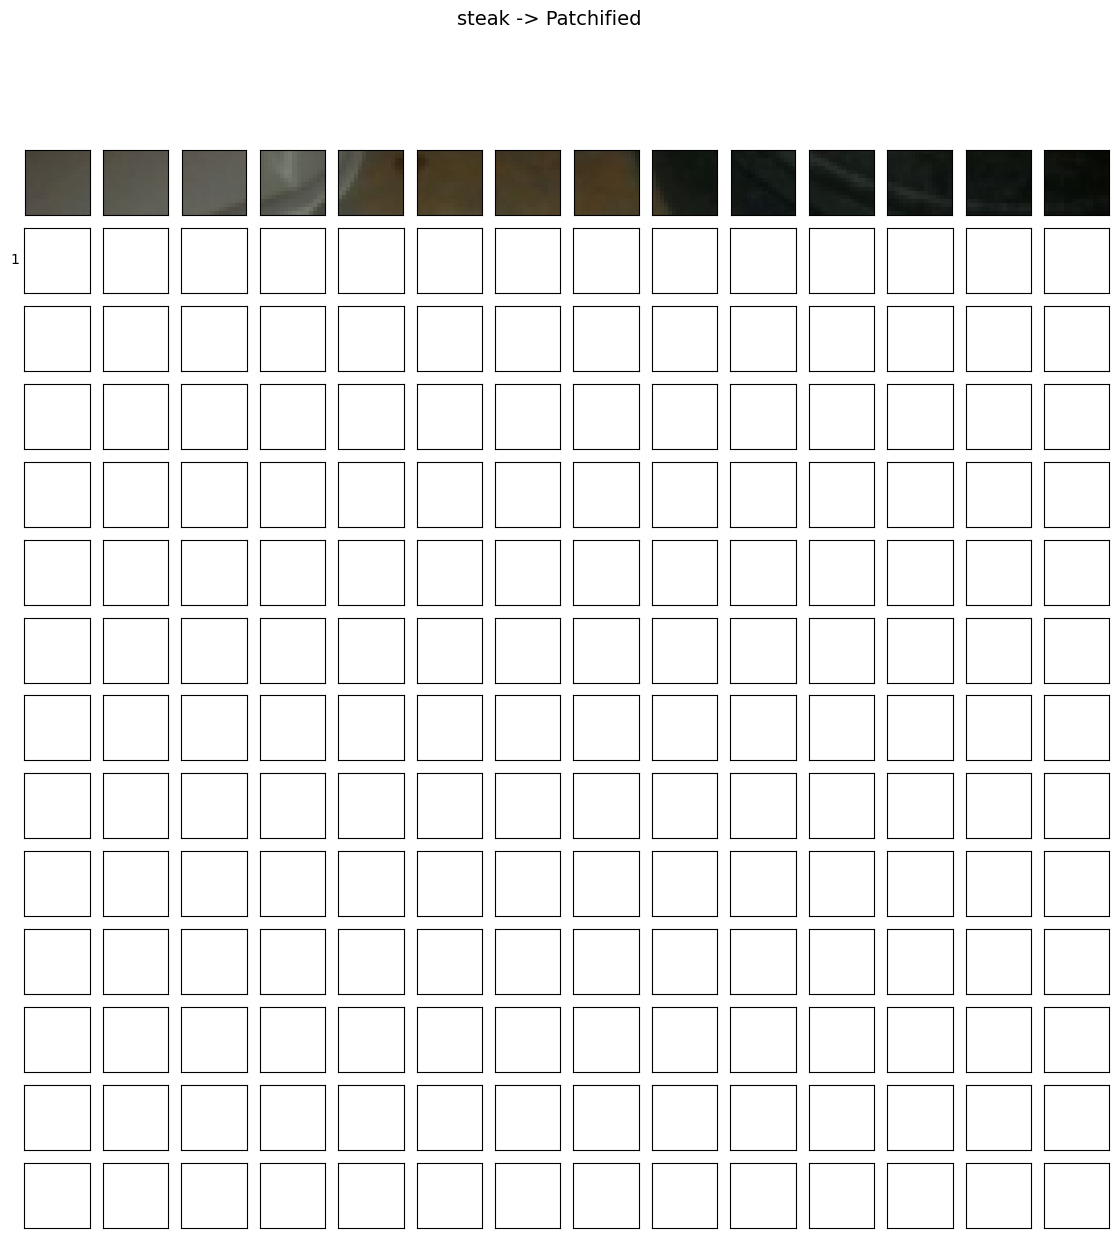

In [17]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisble by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of pataches per columns: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    #Plot the permuted image on the differnt axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate throught height
                                    patch_width:patch_width+patch_size,
                                    :]) # get color channels

    # Set up label information for each subplot (patch)
    axs[1, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[1, j].set_xlabel(j+1)
    axs[1, j].set_xticks([])
    axs[1, j].set_yticks([])
    axs[1, j].label_outer()

  # set up a title for the plt
  fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
  plt.show()

## 4.3 Creating image patchs and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`



In [18]:
# Creae conv2d layer to turn image into patches of learnable feature maps (embeddings
from torch import nn

# Set the patch size
patch_height

# Create a conv2d layer with hyperparamters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, # D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

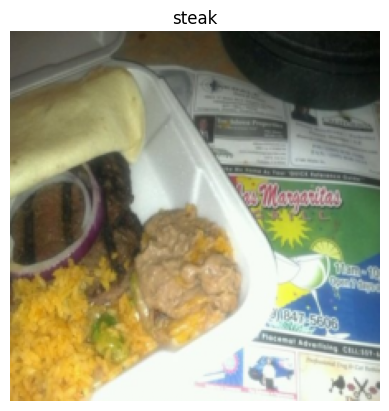

In [19]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image throught the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, )
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image tgo our `conv2d` layer, i's shape is:
```python
torch.Size(1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

In [21]:
image_out_of_conv.requires_grad


True

Showing random convolutional feature maps from indexes: [32, 670, 667, 372, 112]


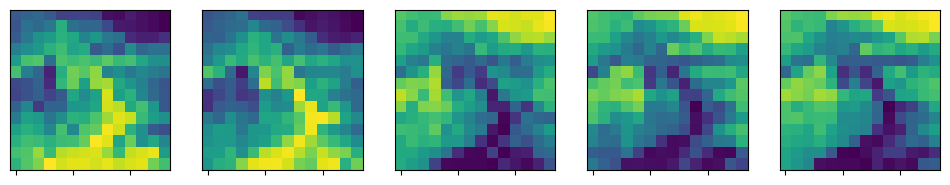

In [22]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Creae plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # Index on the output tensor
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], yticks=[])

In [23]:
# get a single featuer map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.1011,  0.1154,  0.1273,  0.1511,  0.0870,  0.1007,  0.0864,
            0.0891,  0.0375,  0.0331,  0.0189,  0.0505,  0.0365,  0.0232],
          [ 0.1291,  0.1232,  0.1619,  0.1441,  0.1288,  0.0580,  0.1092,
            0.1216,  0.0438,  0.0481,  0.0479,  0.0547,  0.0194,  0.0201],
          [ 0.1372,  0.1292,  0.1712,  0.2039,  0.2465,  0.2129,  0.0600,
            0.1755,  0.1448,  0.0934,  0.0275,  0.0501,  0.0434,  0.0333],
          [ 0.1627,  0.2023,  0.2109,  0.2372,  0.2784,  0.2045,  0.2489,
            0.0759,  0.2085,  0.1375,  0.1874,  0.1496,  0.0933,  0.1269],
          [ 0.1818,  0.1976,  0.2425,  0.2864,  0.3283,  0.2031,  0.2467,
            0.1879,  0.2235,  0.1477,  0.2098,  0.1790,  0.1367,  0.1754],
          [ 0.2738,  0.2754,  0.1648,  0.0369,  0.2389,  0.2617,  0.2120,
            0.3070,  0.0761,  0.2941,  0.3255,  0.2876,  0.1173,  0.0234],
          [ 0.1277,  0.1260,  0.0489, -0.0081,  0.2335,  0.2599,  0.2454,
            0.2375,  0.2987,  0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings tos atisfy the input criteria of the ViT Transformer Encoder.

In [24]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [25]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: tensor([[[ 0.1011,  0.1154,  0.1273,  ...,  0.3146,  0.1842,  0.2176],
         [-0.0622, -0.0703, -0.0896,  ..., -0.1798, -0.1704, -0.1656],
         [ 0.1961,  0.2130,  0.1998,  ...,  0.5606,  0.3725,  0.4475],
         ...,
         [ 0.0420,  0.0538,  0.0511,  ...,  0.2571,  0.1025,  0.1404],
         [ 0.1134,  0.1334,  0.1639,  ...,  0.4162,  0.2104,  0.2594],
         [-0.0874, -0.0923, -0.1167,  ..., -0.2587, -0.1446, -0.1584]]],
       grad_fn=<ViewBackward0>)


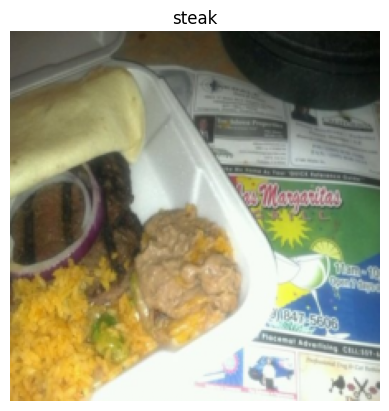

In [26]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feture maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened}")

In [27]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1) # Rearrange output of flattened layer
image_out_of_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

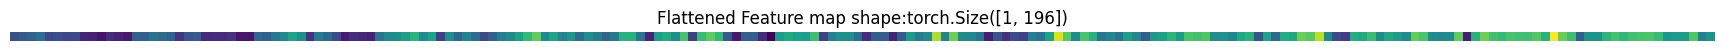

In [28]:
# Get a single flattende feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]


# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened Feature map shape:{single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, patch size
3. Create a lyer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` that defines the forward computation (e.g. Pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [29]:
# 1 Creare a class called PatchEmbeeding]
class PatchEmbeeding(nn.Module):
  #2. Iniitalize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    # 3. Create a layer to turn an iamge into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

    #5. Define a forward method to define the forward computation steps
    def forward(self, x):
      # Create assertion to check that inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size; {self.path_size}"

      # Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      # 6. Make the returned sequence embedding dimesnions are in the right order (batch_)
      return x_flattened.permute(0, 2, 1)

In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape; {patch_embedded_image.shape}")

NameError: name 'PatchEmbedding' is not defined

In [ ]:
!pip install timm

import torch
from timm import create_model

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load an image
image = torch.randn(3, 224, 224)

# Create an instance of the patch embedding layer
patchify = create_model('vit_base_patch16_224', pretrained=False, in_chans=3)

# Pass the image through the patch embedding layer
patch_embedded_image = patchify.patch_embed(image)

# Print the input and output shapes
print(f"Input image size: {image.shape}")
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

In [ ]:
image = image.unsqueeze(0)

In [ ]:
!pip install timm

import torch
from timm import create_model

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load an image
image = torch.randn(3, 224, 224)

# Reshape the image to have four dimensions
image = image.unsqueeze(0)

# Create an instance of the patch embedding layer
patchify = create_model('vit_base_patch16_224', pretrained=False, in_chans=3)

# Pass the image through the patch embedding layer
patch_embedded_image = patchify.patch_embed(image)

# Print the input and output shapes
print(f"Input image size: {image.shape}")
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

### 4.6 Creating the class token embedding
want to: preprend a learnable class token to start the patch embedding.

In [ ]:
patch_embedded_image.shape

In [ ]:
# Get the batch size and embeding dimesnion
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

In [ ]:
# Create a class token embedding as a learnable parameter that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                                      requires_grad=True)
class_token.shape

In [ ]:
patch_embedded_image.shape

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimensions
print(patch_embedded_image_with_class_embedding)
print(f"Sequence fo patch embeddings with calss token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

### Creating the class token embedding
Want to: preprend a learnable class token to the start of the patch emebdding.

In [ ]:
patch_embedded_image

In [ ]:
# Get the batch size and embedding dimesion
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

In [ ]:
# Create calss token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


In [ ]:
patch_embedded_image.shape

In [ ]:
# Add the class token to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) #number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Seqence of patch embeddings with class token preprended shape: {patch_embedded_image_with_class_embedding.shape} -> {batch_size}")

### 4.7 Creating the position embedding

want to: create a series of 1D learnable positon embeddings and to add them to the sequence of patch embeddings


In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D positon embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape


In [ ]:
# Add the positon embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_positon_embedding)
print(f"Patch and position emebdding shape: patch_and_positon_embedding.shape")

### 4.8 Putting it all together. from image to embedding

we've written code to turn an image in a flattened sequence of patch embeddings

Now lets see i tall in one cell

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. print shapes of the original image tensor and get the iamge dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dime=768)

# 5. Pass input through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure its learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_emebdding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the positon embedding to pathc embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding}")

## Equation 2: Multi Head Self Attention

* Multihead self attention: which part of a sequence should pay the most attention to itself?
* In our case we have series of embedded image patches, whihc patch signigicantly relates to anotehr patch.
* We want our neural network (ViT) to learn this relationship/representation
* To replicate MSA in pytorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. it enables smoother gradients, faster training, and better generalisation accuracy/=.
* Normalization = make everything have the same mean and standard deviation
* When we normaize along the embedding dimension, it's like making all of the stairs in a staircase the same size

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA" for short)
  """
  def __init__(self,
               embedding_dim:int=768,# Hidden size D (embedding dimension) from table 1
               num_heads:int=12,# Heads from Table 1 for ViT Base
               attn_dropout:int=0):
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    super.__init__()

    # Create multi head attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                       num_heads=num_heads,
                                       dropout=attn_dropout,
                                       batch_first=True) # is the batch first? (batch, seq, feature) --> (batch, number_ofpatches, embedding_dimension)
def forward(self, x):
  x = self.layer.norm(x)
  attn_ouput, _ = self.multihead_attn(query=x,
                                      key=x,
                                      value=x,
                                      need_weights=False)
  return attn_output

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block": {patch_and_position_embedding})
print(f"Output shape of MSA block: {patched_image_through_msa_block}")

## 6. Equation 3. Multi layer peceptron block

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
* MLP = a quite broad term for a block with a series of layer(s), layers can ebe mulitple or evn only one hidded layer.
* Layer can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In pytorch, the're often called `torch.nn.Linear()` and in Tensorflow they might be called `tf.keras.layers.Dense()`
* GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELY.html#torch.nn.GELU
* **Dropout** = Dropout when used, is applied after every dense layer except for the qkv-projections and directly after adding positional-to patch embeddings. Hybrid models are trained with the exact setup as thier ViT Computers
* MLP number of hidden units = MLP Size in Table 1
In pseudocode:
```python
# MLP
x = linear -> non_linear -> dropout -> non-linear dropout
```


In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout)
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

    def forward(self, x):
      x = self.layer_norm(x)
      x = self.mlp(x)
      return x
      # return self.mlp(self.layer_norm(x)) # same as above


In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block}")

## 7. Creating the transformer Encoder

The transformer Encoder is an atternative blocks of MSA (equation 2) and MLP (equation 3)

And there are resudual connections between each block

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks

in pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block ->
```

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:init=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                num_heads=num_heads,
                                                attn_dropout=attn_dropout)
    # Create the MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

    def forward(self, x):
      x = self.msa_block(x) + x # residual/skip connection for equation 2
      x = self.mlp_block(x) + x # residual/skip connection for equation 3
      return x


In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block:
        input_size= (1, 197, 768), # (batch_size, num_of_patches, embedding_dimension)
        col_names=["input_size", "output_size",]
        col_width=20,
        row_setting["var_names"])

### 7.2 Create a transformer encoder layer with in-built pytorch layers

so far we've created a transformer encoder by hand.

but because of how good the transformer arch

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

In [ ]:
# Get a summary using torchinfo.summmary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

## 8. Putting it all together to create ViT

In [ ]:
# Create a Vit Class
class Vit(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for Layers for Vit Base
               embedding_dim:int=768, # Hidden size D from table
               mlp_size=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout=0.1,
               embedding_dropout:int=0.1,# Dropout for patch and postion embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

  # Make an assertion tht the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch**2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable positon embeddings
    self.position_embedding = nn.Parameter(data=torch.tadn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch emebdding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create Transformer Encoder block
    self.transformer_encoder = nn.Sequential(8[TransformerENcoderBlock(embedding_dim=emebddign_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_sze=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # Create classifer head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def foward(self, x):



In [ ]:
# Create a ViT class:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # table 3 from the ViT paper
               in_channel:int=3,
               patch_size:int=16,
               num_transformer_layer:int=12, # Table 1 for "layers"
               embedding_dim:int=768, # Hidden size D from table 1 for ViT base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and postion embeddings
               num_classes:int=1000):
    super().__init__

    # Make an assertion that the image size is compartible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size:{patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.rand(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embediing dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch.embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

  # Create the transformer encoder block
  self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                     num_heads=num_heads,
                                                                     mlp_size=mlp_size,
                                                                     mlp_dorpout=mlp_dropout) for _ in range(num_transformer_layers)])

  # Create classifier head
  self.classifier = nn.Sequential(
      nn.LayerNorm(normalized_shape=embedidng_dim),
      nn.Linear(in_features=embedding_dim,
                out_features=num_classes)

  )

  def forward(self, x):
    # get the batch size
    batch_size = x.shape[0]
    # Create the class token embedding and expand it to match the batch size 9equation 1
    class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' means to iner the dimension

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropoyt to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier
    x = self.classifer(x[:, 0])
    return x

In [ ]:
vit = ViT()
vit

In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_iamge_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (paizza, steak and sushi)
vit = ViT(num_classes=1000)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

### 8.1 Getting the visual summary of our ViT model

In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=1000),
        input_size=(1, 2, 224, 224), # (batch_size, number_of_patches, embedding dimension)
        col_names=["input_size", "output_siz", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'])

In [ ]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                               required_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

## 9. Setting up training code for our custom ViT

We've replicataed the vit architecture, now lets see how to performs on or FoodVision Data

### 9.1 Creating an Optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defualts) and a weight decay of 0.1

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The Vit paper doesnt acutually mention what loss function they used.
So since it's multi-class classification we'll use the torch.nn.CrossEntropyLoss()

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

## 9.3 Training our ViT Model


In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrfossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=rest-dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

results = engine.train()

### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated model architecture correctly.

But waht was different between our training procedure (to get such poor results)
and teh ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase over time
* Learning rate - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

Searcg "pytorch [technique name]"

### 9.5 Plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

### 10. Using a pretrained VoT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, its often a good place to start. If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with lttle data

# The following requires torch v0.12+ and torchvision 0.13+



In [31]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.2.1+cu121
0.17.1+cu121


In [34]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Set up a ViT model isntance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requiers_grad = False

# Update the classifer head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=769, out_features=len(class_names)).to(device)

In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_setting=['var_names'])

### 10.3 Preparing data for the pretrained model

when using a pretrained model, you want to make sure your data is formated in the same way that the model was trained on


In [35]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

NameError: name 'pretrained_vit_weights' is not defined

In [ ]:
# Set up dataloaders
train_dataloader_pretrained, test_datalaoder_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transforms=vit_transforms,
                                                                                                     batch_size=32) # could set a higer batch size because using a pretrained model

#10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# create opimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretraned_vit_results = engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test-dataloader_pretrained,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

### 10.5 Plot the loss curves of our pretrained ViT extactor model

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite wll, how about we save it to a file and then check its filesize

We want to check the filesize beacuse  if we wanted to deploy a model to say a website/mobile application, we may limitation

In [36]:
# Save the model
from going_modular.going_modulal impor tutils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to mmegabytes
pretrained_vit_model = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pertrained_vit_model_size} MB")

## 11. Predicting on a custom image

Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it(e.g hard to deploy such a large file/might not make predictions as fast as a smaller model).

In [ ]:
import requests

# import fucntion to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Downloade the image if it deosnt already exist
if not custom_image.is_file():
  with open(custom_image_path, "wb") as f:
    # when downloading from Gihyb, need to use the 'raw' file link
    request = request.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/image")
    print(f"Downlioading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download")

# Predict on custom image
pred_and_plot_imagfe(model(model=pretrained_vit,
                           image_path=cusotm_image_path,
                           class_names=class_names))

In [ ]:
~
